<h1><center><font size="6">Santander Customer Transaction Prediction</font></center></h1>
<h1><center><font size="5">Can you identify who will make a transaction?</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg" width="500"></img>

<br>
<b>
    
Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.</b>
     


<a id=1><pre><b>Load Packages</b></pre></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numba import jit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings('ignore')
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

<a id=1><pre><b>Import the Data</b></pre></a>

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']
print ("Data is ready!")

Data is ready!


In [3]:
print ("Test ",test.shape)
print ("Train ",train.shape)

Test  (200000, 201)
Train  (200000, 202)


In [4]:
train.head(2)

ID_code  target    var_0   var_1    var_2  var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.093  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.389  12.3622  7.0433  5.6208   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  

[2 rows x 202 columns]

**Target = 0 or Target = 1, binary classification**

In [5]:
train.describe()

target          var_0      ...              var_198        var_199
count  200000.000000  200000.000000      ...        200000.000000  200000.000000
mean        0.100490      10.679914      ...            15.870720      -3.326537
std         0.300653       3.040051      ...             3.010945      10.438015
min         0.000000       0.408400      ...             6.299300     -38.852800
25%         0.000000       8.453850      ...            13.829700     -11.208475
50%         0.000000      10.524750      ...            15.934050      -2.819550
75%         0.000000      12.758200      ...            18.064725       4.836800
max         1.000000      20.315000      ...            26.079100      28.500700

[8 rows x 201 columns]

Let's see basic stats on the 2 different groups.

In [5]:
train[train['target']==0].describe()

target          var_0          var_1          var_2          var_3  \
count  179902.0  179902.000000  179902.000000  179902.000000  179902.000000   
mean        0.0      10.626681      -1.695770      10.665876       6.788979   
std         0.0       3.008564       4.024813       2.612961       2.040082   
min         0.0       0.408400     -15.043400       2.117100      -0.040200   
25%         0.0       8.429500      -4.790775       8.698025       5.247625   
50%         0.0      10.478600      -1.682600      10.529000       6.817000   
75%         0.0      12.693075       1.287700      12.463900       8.317875   
max         0.0      20.315000      10.376800      19.353000      13.188300   

               var_4          var_5          var_6          var_7  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean       11.072412      -5.146736       5.389620      16.549306   
std         1.620103       7.827522       0.857983       3.417700   
min         5.074800     -32.562600       2.347300       5.349700   
25%         9.880600     -11.260950       4.756425      13.950125   
50%        11.104400      -4.917700       5.364400      16.460850   
75%        12.253100       0.844600       5.981300      19.108800   
max        16.671400      17.251600       8.447700      27.691800   

               var_8  ...        var_190        var_191        var_192  \
count  179902.000000  ...  179902.000000  179902.000000  179902.000000   
mean        0.262347  ...       3.149130       7.390800       1.949017   
std         3.331105  ...       4.522568       2.997847       1.476456   
min       -10.505500  ...     -14.093300      -2.691700      -3.814500   
25%        -2.342575  ...      -0.111850       5.130825       0.915300   
50%         0.371400  ...       3.117250       7.297000       1.928950   
75%         2.919300  ...       6.296375       9.461300       2.969800   
max        10.151300  ...      18.440900      16.716500       8.402400   

             var_193        var_194        var_195        var_196  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean        3.355403      18.017716      -0.155601       2.260297   
std         3.982819       3.127715       1.422275       5.441118   
min       -10.845500       8.694400      -5.261000     -14.209600   
25%         0.612400      15.656700      -1.178700      -1.987375   
50%         3.417550      17.982400      -0.184200       2.359700   
75%         6.217075      20.417500       0.813000       6.513425   
max        18.281800      27.928800       4.272900      18.321500   

             var_197        var_198        var_199  
count  179902.000000  179902.000000  179902.000000  
mean        8.919032      15.924058      -3.415273  
std         0.917467       2.978539      10.434525  
min         5.960600       6.299300     -38.852800  
25%         8.262100      13.896000     -11.312025  
50%         8.897700      15.988500      -2.914000  
75%         9.601500      18.095400       4.741400  
max        12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [7]:
train[train['target']==1].describe()

target         var_0      ...            var_198       var_199
count  20098.0  20098.000000      ...       20098.000000  20098.000000
mean       1.0     11.156418      ...          15.393283     -2.532243
std        0.0      3.270293      ...           3.248123     10.435910
min        1.0      0.452800      ...           6.558700    -38.852800
25%        1.0      8.695875      ...          13.232500    -10.285050
50%        1.0     11.001350      ...          15.427950     -1.971850
75%        1.0     13.343700      ...          17.776425      5.701475
max        1.0     19.458300      ...          25.857100     24.564600

[8 rows x 201 columns]

**Missing data**

In [8]:
print ("Missing data at training")
train.isnull().values.any()

Missing data at training


False

In [9]:
print ("Missing data at test")
test.isnull().values.any()

Missing data at test


False

**There is no missing data**

In [6]:
train = train.drop(["ID_code", "target"], axis=1)

### Check for Class Imbalance

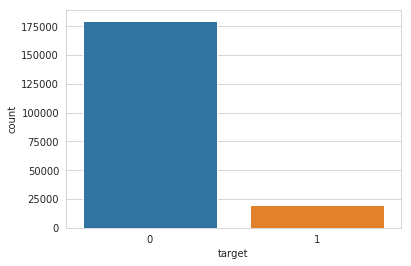

In [11]:
sns.set_style('whitegrid')
sns.countplot(target)
sns.set_style('whitegrid')

<a id=1><pre><b>Classification augment</b></pre></a>

In [16]:
@jit
def augment(x,y,t=4):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

# Build the Light GBM Model

<a id=1><pre><b>Parameters</b></pre></a>

In [17]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [18]:
#kfold = 15
#folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
num_folds = 5
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

<a id=1><pre><b>Run LGBM model</b></pre></a>

In [19]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.910004	valid_1's auc: 0.894815
[10000]	training's auc: 0.918849	valid_1's auc: 0.899071
[15000]	training's auc: 0.925377	valid_1's auc: 0.899613
Early stopping, best iteration is:
[14437]	training's auc: 0.924706	valid_1's auc: 0.899677
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.911486	valid_1's auc: 0.894343
[10000]	training's auc: 0.920356	valid_1's auc: 0.89787
[15000]	training's auc: 0.9268	valid_1's auc: 0.898113
Early stopping, best iteration is:
[14322]	training's auc: 0.92597	valid_1's auc: 0.898187
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.909325	valid_1's auc: 0.898983
[10000]	training's auc: 0.91828	valid_1's auc: 0.902094


KeyboardInterrupt: 

In [14]:
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


 >> CV score: 0.90065 


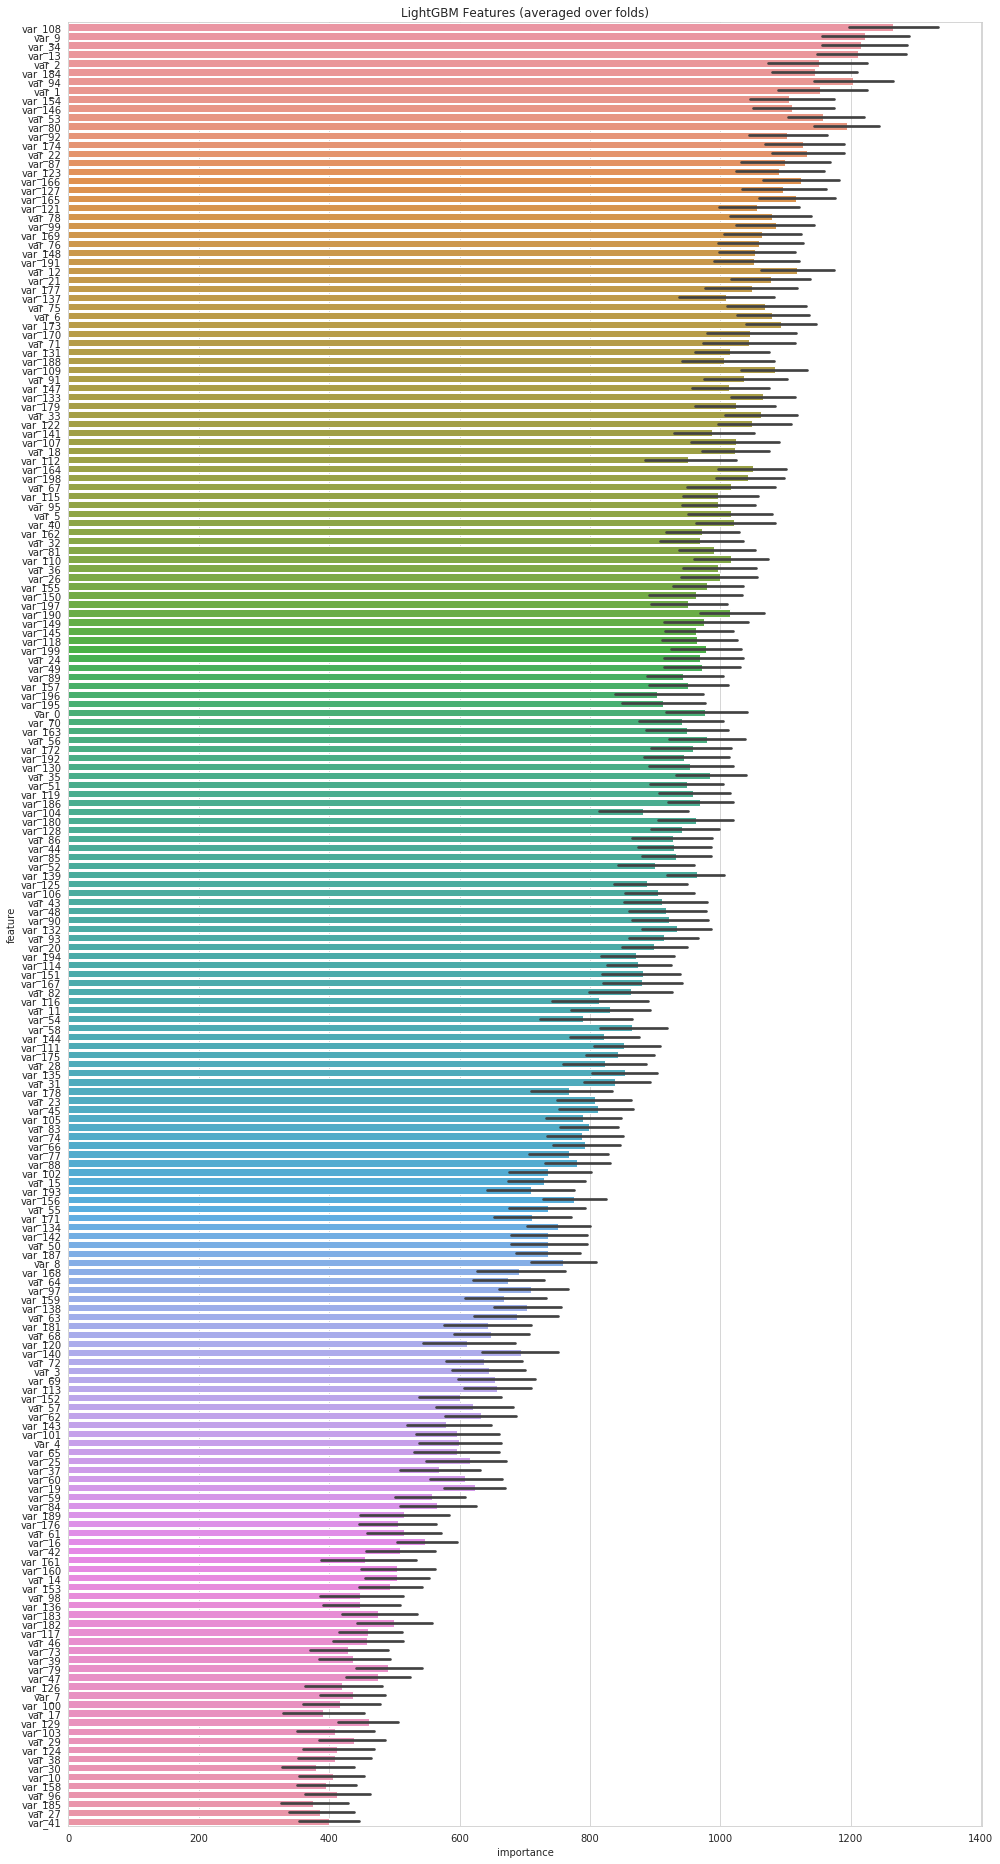

In [17]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# Submission

In [15]:
submission = pd.DataFrame({"ID_code": test.ID_code.values})
submission["target"] = predictions
submission.to_csv("submission_aug.csv", index=False)

In [19]:
submission.head()

ID_code    target
0  test_0  0.142333
1  test_1  0.274733
2  test_2  0.241985
3  test_3  0.291388
4  test_4  0.058313